## Toxic comment classification
Dataset is a large number of Wikipedia comments which have been labeled by human raters for toxic behavior.

**The types of toxicity are:**
- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

**Objective**

- Classify comments by toxicity.

**method**
- I will train an XLNET pretrained models from hugging face library and check its performance with kaggle submission results

**Note**
- a comment can belong to multiple classes (multilabel classification)
- majority of the data is unlabeled which means that these comments are not toxic.

In [1]:
! pip install transformers
! pip install SentencePiece

     |████████████████████████████████| 1.8MB 5.5MB/s 
     |████████████████████████████████| 2.9MB 32.1MB/s 
     |████████████████████████████████| 890kB 44.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=b7377871c563ed0af42596d2f38662803d55dfaeccf402587cd1c1acc76eac08
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.2MB 4.4MB/s 


In [2]:
import os
import math
import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU  Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Import Dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
train = pd.read_csv('/content/drive/My Drive/Data_toxic_comments/train.csv', index_col='id')
test = pd.read_csv('/content/drive/My Drive/Data_toxic_comments/test.csv', index_col='id')

## Data exploring

In [ ]:
train.head(5)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
train.shape

(159571, 7)

In [ ]:

unlabeled_data = train.drop(columns={'comment_text'})[(train.drop(columns={'comment_text'}) == 0).all(axis=1)]
print(f'{round(len(unlabeled_data)/train.shape[0] *  100, 2)}% of the comments are not labeled')

89.83% of the comments are not labeled


In [ ]:
tox_count = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
tox_count = tox_count.T.reset_index().rename(columns={'index': 'label'})

tox_count["count"] = tox_count.sum(axis=1).astype(int)
tox_count = tox_count[['label', 'count']].append({'label': 'no label', 'count': len(train) - tox_count['count'].sum()}, ignore_index=True)

In [ ]:
tox_count

id,label,count
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405
6,no label,124473


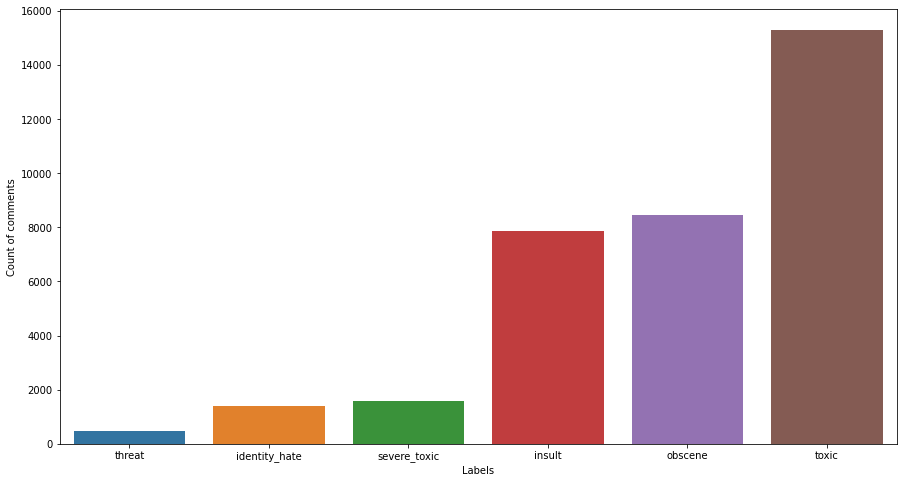

In [ ]:
plt.figure(figsize=(15, 8))
sns.barplot(x="label", y="count", data=tox_count[0:6].sort_values(by=('count')))
plt.xlabel('Labels')
plt.ylabel('Count of comments')
plt.show()

### Examining comment length

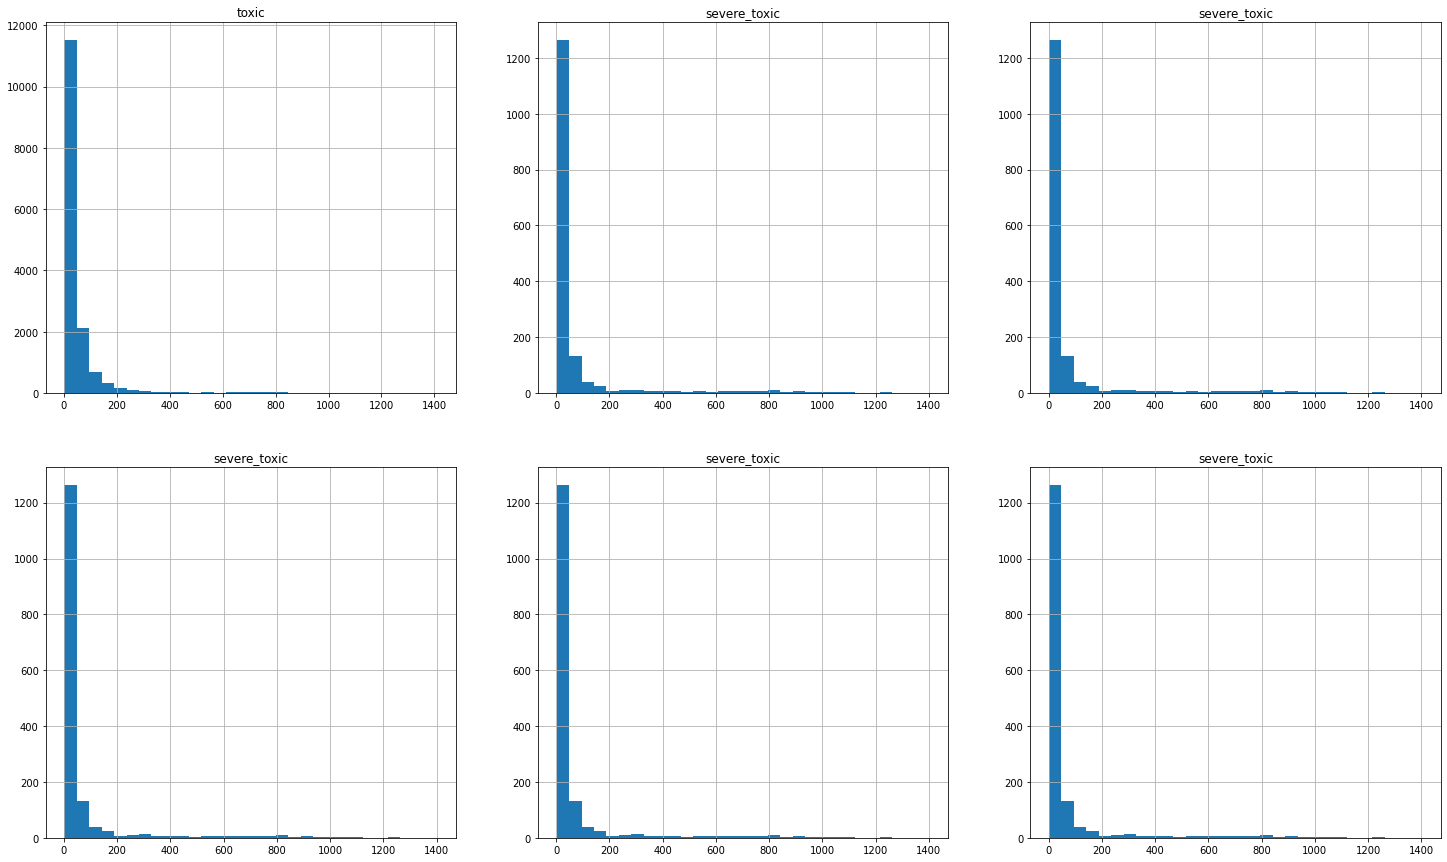

In [ ]:
train['length_comment'] = train['comment_text'].str.split().str.len()
fre_d = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'length_comment']]
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

fig, axes = plt.subplots(2, 3, figsize=(25, 15))
counter=0
for row in range(2):
    for col in range(3):
        fre_d[fre_d[labels[counter]] == 1]['length_comment'].hist(ax=axes[row,col], bins=30)
        axes[row,col].set_title(labels[counter])
        counter=+1
        
plt.show()


All the six categories have the same distribuation comments length

## Correlation between comments

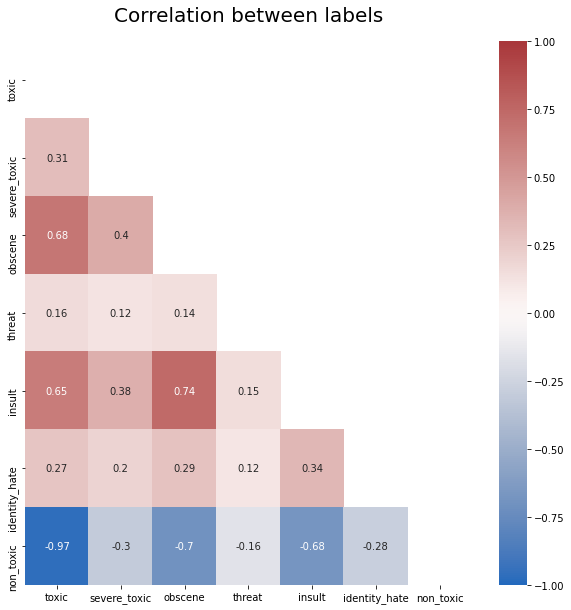

In [ ]:
train["non_toxic"] = np.where((train["toxic"] == 0) & (train["severe_toxic"] == 0) & (train["obscene"] == 0) & (train["threat"] == 0) & (train["insult"] ==0) & (train["identity_hate"] == 0),1,0)
data_labels = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'non_toxic']]
plt.figure(figsize = (10,10))
plt.title('Correlation between labels', fontsize=20, pad=20)

corr = data_labels.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(corr, mask=mask, annot = True, cmap="vlag", vmin=-1, vmax=1)
plt.show()


- We can see that toxic, insult, and obscene comments come togeter

### XLNET

XLNET: from hugging face library we will use xlnet-base-cased model since it is important to consider the case of the letters in commenting.
- Implemented by following Josh Xin Jie Lee tutorial 

## Preprocess Data

In [8]:
# load the model 
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

In [10]:
train_text_list = train["comment_text"].values
test_text_list = test["comment_text"].values

In [11]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):

    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def attention_masks(input_ids):

    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [12]:
# input id tokens
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=250)
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=250)
#attention mask
train_attention_masks = attention_masks(train_input_ids)
test_attention_masks = attention_masks(test_input_ids)


In [13]:
train["features"] = train_input_ids.tolist()
train["masks"] = train_attention_masks

test["features"] = test_input_ids.tolist()
test["masks"] = test_attention_masks

In [14]:
# split data for training and validation
train, valid = train_test_split(train, test_size=0.2, random_state=42)

In [15]:
X_train = train["features"].values.tolist()
X_valid = valid["features"].values.tolist()

train_masks = train["masks"].values.tolist()
valid_masks = valid["masks"].values.tolist()

label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
Y_train = train[label_cols].values.tolist()
Y_valid = valid[label_cols].values.tolist()

In [16]:

X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

In [17]:
batch_size = 16
train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,sampler=validation_sampler,batch_size=batch_size)

## Training

In [ ]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):

  model.to(device)

  for i in trange(num_epochs, desc="Epoch"):
    actual_epoch = start_epoch + i
    model.train()

    tr_loss = 0
    num_train_samples = 0

    for step, batch in enumerate(train_dataloader):
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch
      optimizer.zero_grad()
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      loss.backward()
      optimizer.step()

    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("Train loss: {}".format(epoch_train_loss))


    model.eval()

    eval_loss = 0
    num_eval_samples = 0

    for batch in valid_dataloader:
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch
      with torch.no_grad():
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set


def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):

  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
  
def load_model(save_path):

  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

In [ ]:
torch.cuda.empty_cache()

In [ ]:
        
class XLNet_classifier(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNet_classifier, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
    
  def pool_hidden_state(self, last_hidden_state):

    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNet_classifier(num_labels=len(Y_train[0]))
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
num_epochs=2

In [ ]:
cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "/content/drive/My Drive/Data_toxic_comments/xlnet_toxic.bin")

model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

In [ ]:
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

In [ ]:
def predictions(model, df, num_labels, device="cpu", batch_size=32):
  iteration = math.ceil(df.shape[0]/batch_size)
  
  prediction_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(iteration):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      prediction_probs = np.vstack([prediction_probs, logits])
  
  return prediction_probs

In [ ]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, test, num_labels, device="cuda", batch_size=32)
pred_probs

In [ ]:
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

test["toxic"] = pred_probs[:,0]
test["severe_toxic"] = pred_probs[:,1]
test["obscene"] = pred_probs[:,2]
test["threat"] = pred_probs[:,3]
test["insult"] = pred_probs[:,4]
test["identity_hate"] = pred_probs[:,5]

In [ ]:
test_to_csv = test.reset_index()
test_to_csv.head()

,id,comment_text,features,masks,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,"[17, 4333, 15683, 17, 1653, 1614, 27, 70, 2718...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.973646e-01,6.810126e-01,9.943510e-01,2.811275e-01,9.655939e-01,6.173821e-01
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,"[5847, 5383, 40, 17, 213, 722, 369, 5847, 5383...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",3.463730e-06,1.105590e-06,2.950960e-07,2.665337e-07,1.079900e-07,1.663244e-07
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...","[17, 12, 5847, 5383, 1675, 5847, 5383, 6940, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.510164e-06,3.645308e-07,3.329686e-07,3.394477e-07,1.168160e-07,1.529464e-07
3,00017563c3f7919a,":If you have a look back at the source, the in...","[17, 60, 1963, 44, 47, 24, 338, 126, 38, 18, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.565799e-08,7.156541e-08,4.725178e-09,3.286844e-08,2.539988e-08,2.742011e-08
4,00017695ad8997eb,I don't anonymously edit articles at all.,"[17, 150, 220, 26, 46, 9502, 111, 8619, 2883, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.958533e-06,1.661719e-07,1.494095e-07,2.325547e-07,1.739687e-07,1.017955e-07


In [ ]:
cwd = os.getcwd()
pred_save_path = output_model_file = os.path.join(cwd, "drive/My Drive/Data/toxic_2_epoch.csv")
test_to_csv[["id", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].to_csv(pred_save_path, index=False)

## Results submission kaggle
- In the first time I run the model without freezing the network
- In the second run I trained the model with freezing the network
- the higher score 98.2 was for the first implemetaion


<img src="Picture1.png" alt="Drawing" style="width: 800px;"/>

